In [9]:
using Missings
using StatsKit
using MLJ
import AlgebraOfGraphics as AOG
using CairoMakie

set_theme!(theme_dark())
ENV["DATAFRAMES_ROWS"] = 8

8

##### Data Cleaning

In [15]:
function processpassengerData(passengerData::DataFrame)::DataFrame
    passengerData = select(passengerData, Not([:Name]))
    passengerData.Cabin = coalesce.(passengerData.Cabin, "//")
    passengerData.RoomDeck = [
        String(deck[1]) for deck in split.(passengerData.Cabin, "/")
    ] |> categorical
    passengerData.RoomSide = [
        String(deck[3]) for deck in split.(passengerData.Cabin, "/")
    ] |> categorical
    passengerData.TotalSpent = passengerData.RoomService + passengerData.FoodCourt + passengerData.ShoppingMall + passengerData.Spa + passengerData.VRDeck
    passengerData = select(passengerData, Not(:Cabin))
    return passengerData
end

passengerData = CSV.read("data/train.csv", DataFrame) |>
                dropmissing |>
                processpassengerData

Row,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,RoomDeck,RoomSide,TotalSpent
,String7,String7,Bool,String15,Float64,Bool,Float64,Float64,Float64,Float64,Float64,Bool,Cat…,Cat…,Float64
1,0001_01,Europa,false,TRAPPIST-1e,39.0,false,0.0,0.0,0.0,0.0,0.0,false,B,P,0.0
2,0002_01,Earth,false,TRAPPIST-1e,24.0,false,109.0,9.0,25.0,549.0,44.0,true,F,S,736.0
3,0003_01,Europa,false,TRAPPIST-1e,58.0,true,43.0,3576.0,0.0,6715.0,49.0,false,A,S,10383.0
4,0003_02,Europa,false,TRAPPIST-1e,33.0,false,0.0,1283.0,371.0,3329.0,193.0,false,A,S,5176.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6603,9278_01,Earth,true,PSO J318.5-22,18.0,false,0.0,0.0,0.0,0.0,0.0,false,G,S,0.0
6604,9279_01,Earth,false,TRAPPIST-1e,26.0,false,0.0,0.0,1872.0,1.0,0.0,true,G,S,1873.0
6605,9280_01,Europa,false,55 Cancri e,32.0,false,0.0,1049.0,0.0,353.0,3235.0,false,E,S,4637.0
6606,9280_02,Europa,false,TRAPPIST-1e,44.0,false,126.0,4688.0,0.0,0.0,12.0,true,E,S,4826.0


#### Exploration Analysis

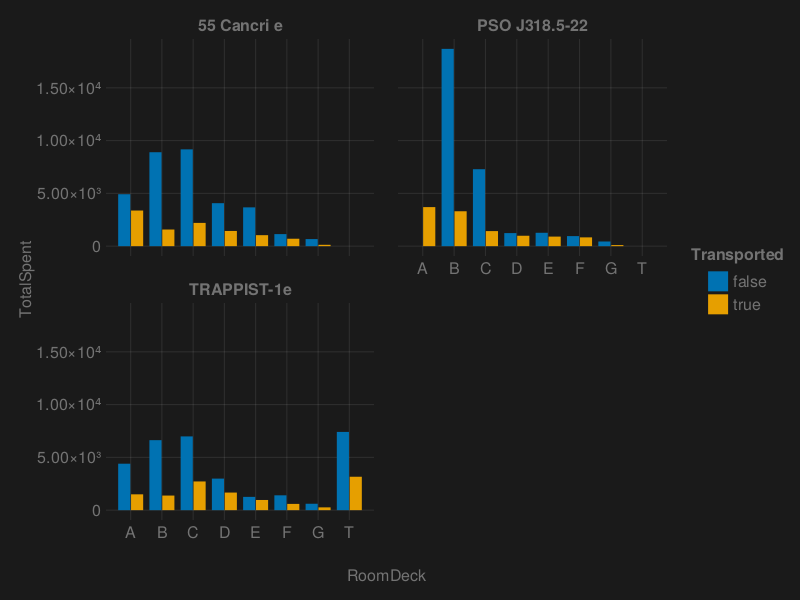

In [14]:
transported_deck = AOG.data(passengerData) *
                   AOG.mapping(:RoomDeck, :TotalSpent, color=:Transported, dodge=:Transported, layout=:Destination) *
                   AOG.expectation()
AOG.draw(transported_deck)

##### Statistical Approach

In [80]:
fn = @formula(Transported ~ VIP + CryoSleep + Age + RoomService)
logitModel = glm(fn, passengerData, Bernoulli(), LogitLink())

function measureAccuracy(model, passengerData::DataFrame)::Float64
    predictions = GLM.predict(model, passengerData)
    predictions = [
        if x < 0.5
            false
        else
            true
        end for x in predictions
    ]
    prediction_df = DataFrame(y_actual=passengerData.Transported, y_predicted=predictions, prob_predicted=predictions)
    prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted
    accuracy = mean(prediction_df.correctly_classified)

    return accuracy

end

acc = measureAccuracy(logitModel, passengerData)

0.7201029367241901

##### Machine Learning Approach

In [81]:
passengerData = MLJ.coerce!(passengerData,
    MLJ.autotype(passengerData)
)

y, X = MLJ.unpack(passengerData, ==(:Transported), !=([:PassengerID, :RoomService, :FoodCourt, :ShoppingMall, :Spa, :VRDeck]), colname -> true)
train, test = MLJ.partition(eachindex(y), 0.7; shuffle=true)
Tree = BetaML.DecisionTreeClassifier()
mach = machine(Tree, X, y; scitype_check_level=0)
MLJ.fit!(mach, rows=train)
pred = MLJ.predict(mach, X[test, :])
yhat = StatsBase.mode.(pred)
MLJ.accuracy(yhat, y[test])


┌ Info: Training machine(DecisionTreeClassifier(max_depth = 0, …), …).
└ @ MLJBase /Users/zachary.drake/.julia/packages/MLJBase/5cxU0/src/machines.jl:492


0.7885973763874874

#### Predictions

In [82]:
predictData = CSV.read("data/test.csv", DataFrame) |>
              dropmissing |>
              processpassengerData

pred = MLJ.predict(mach, predictData)
predictData.Transported = StatsBase.mode.(pred)

select!(predictData, :PassengerId, :Transported)

CSV.write("output/submission.csv", predictData)

"output/submission.csv"